# Twitter EDA
## Data Source
- [Twitter API v2](https://developer.twitter.com/en/docs/twitter-api)

## Data Loading

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
with open('../data/twitter.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data.values())

## Data Exploration

In [4]:
df = df[['cap.english', 'cap.universal', 'user.user_data.followers_count','raw_scores.english.overall', 'raw_scores.universal.overall',  'user.user_data.verified']].rename(columns={'cap.english': 'cap_english','cap.universal':'cap_universal','raw_scores.english.overall':'raw_score_english_overall','raw_scores.universal.overall':'raw_score_universal_overall','user.user_data.followers_count': 'followers_count', 'user.user_data.verified': 'verified'})
df.head()

,cap_english,cap_universal,followers_count,raw_score_english_overall,raw_score_universal_overall,verified
0,0.553973,0.760578,2628300,0.13,0.25,True
1,0.797076,0.808228,47650,0.68,0.73,False
2,0.621687,0.752712,35127,0.16,0.24,False
3,0.226318,0.743721,25007,0.01,0.23,False
4,0.553973,0.792437,1692856,0.13,0.32,True


In [5]:
df.describe()

,cap_english,cap_universal,followers_count,raw_score_english_overall,raw_score_universal_overall
count,908.000000,908.000000,9.080000e+02,908.000000,908.000000
mean,0.763852,0.793424,8.370976e+03,0.605156,0.614559
std,0.191643,0.159017,1.096744e+05,0.354764,0.340963
min,0.000000,0.233324,0.000000e+00,0.000000,0.010000
25%,0.728711,0.767421,3.000000e+00,0.230000,0.260000
50%,0.803671,0.810213,5.300000e+01,0.760000,0.750000
75%,0.891232,0.888526,6.600000e+02,0.930000,0.930000
max,1.000000,1.000000,2.628300e+06,1.000000,1.000000


#### Quantiles

In [6]:
df.quantile([0.6, 0.9, 0.95, 0.99, 0.999], interpolation='lower')

,cap_english,cap_universal,followers_count,raw_score_english_overall,raw_score_universal_overall,verified
0.600,0.828755,0.837213,132,0.84,0.85,False
0.900,0.937364,1.000000,3309,0.99,1.00,False
0.950,1.000000,1.000000,9015,1.00,1.00,False
0.990,1.000000,1.000000,45648,1.00,1.00,True
0.999,1.000000,1.000000,1692856,1.00,1.00,True


## Data Visualization

array([[<AxesSubplot: title={'center': 'cap_english'}>,
        <AxesSubplot: title={'center': 'cap_universal'}>,
        <AxesSubplot: title={'center': 'followers_count'}>],
       [<AxesSubplot: title={'center': 'raw_score_english_overall'}>,
        <AxesSubplot: title={'center': 'raw_score_universal_overall'}>,
        <AxesSubplot: >]], dtype=object)

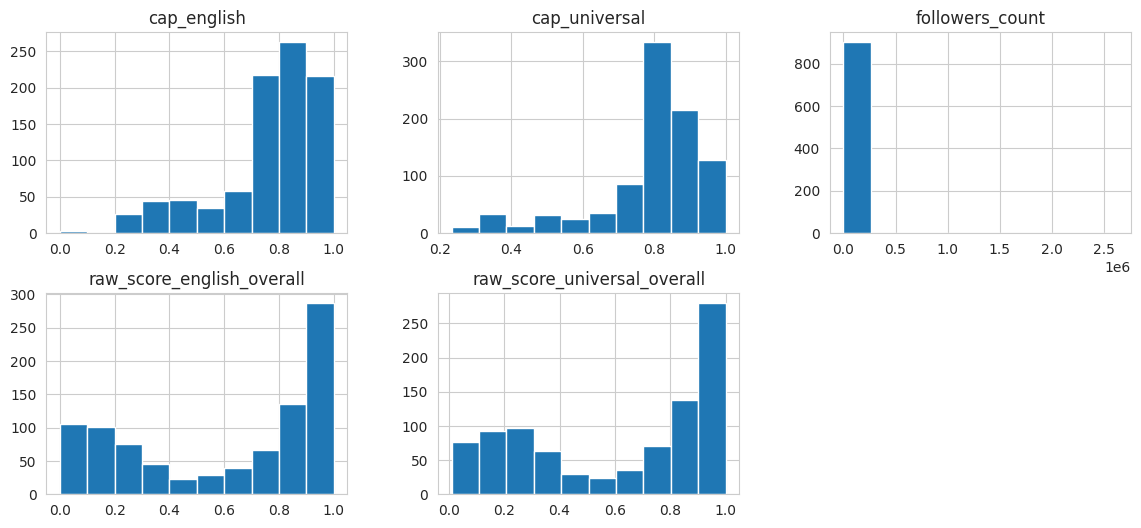

In [7]:
df.select_dtypes('number').hist(figsize=(14,6), layout=(2,3))

### Followers count distribution

<AxesSubplot: >

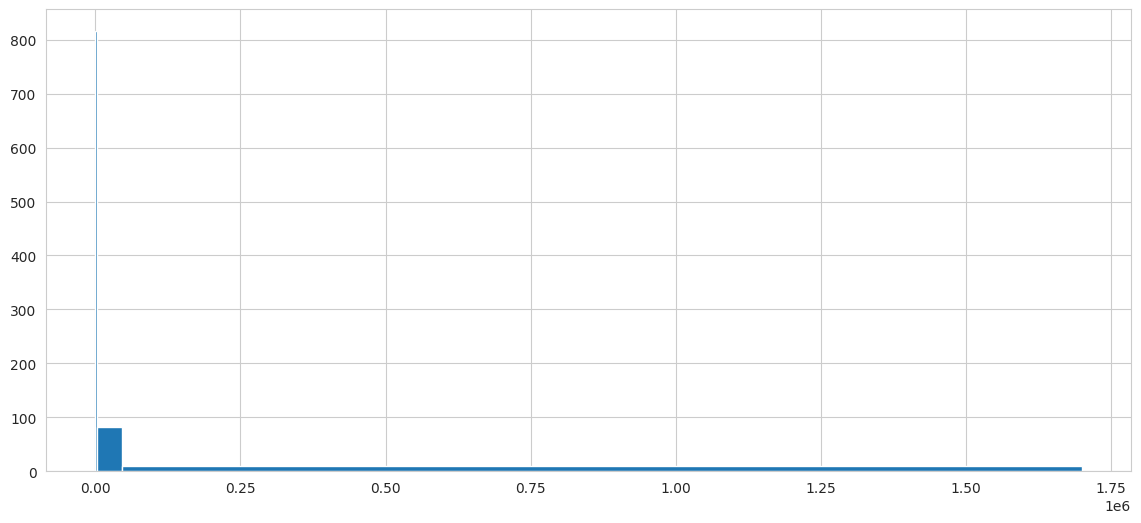

In [8]:
df['followers_count'].hist(figsize=(14,6), bins=[0, 3300, 46000, 1.7e6])

### Verified distribution

<AxesSubplot: ylabel='verified'>

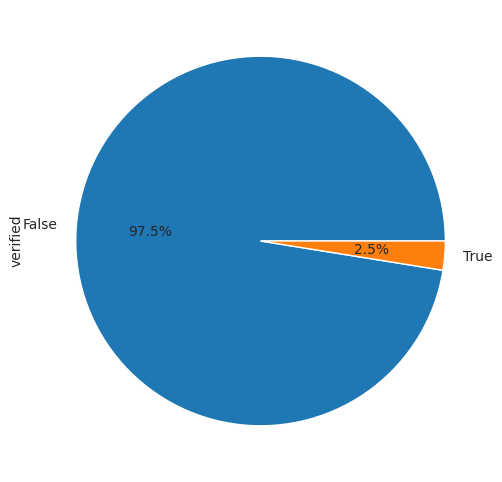

In [9]:
df['verified'].value_counts().plot.pie(figsize=(14,6), autopct='%1.1f%%')

### Correlation cap/raw_score

/home/r1oga/.pyenvs/ig-eda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='cap_universal', ylabel='raw_score_universal_overall'>

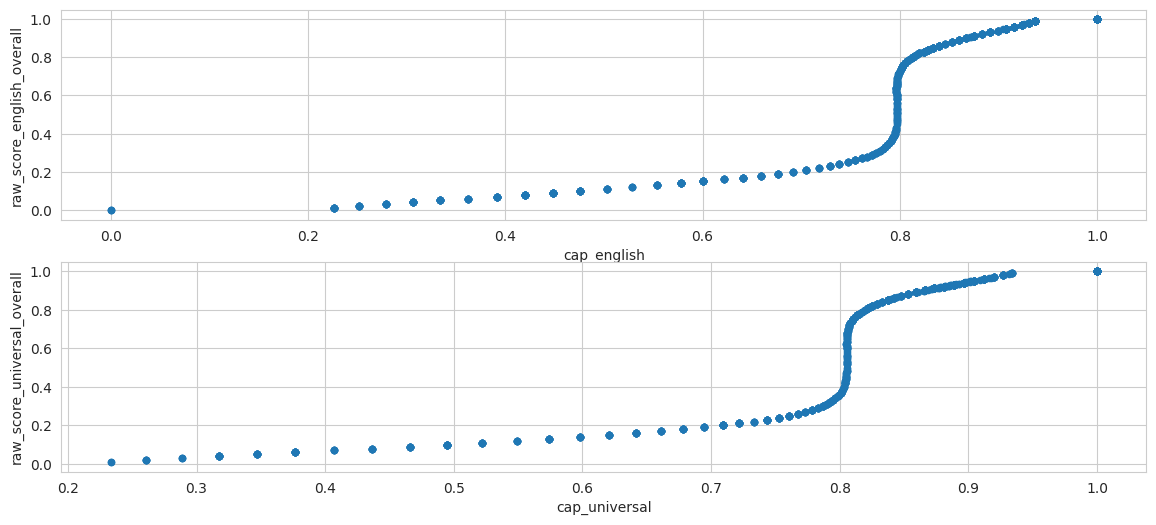

In [10]:
fig, (ax0, ax1) = plt.subplots(2)
df.plot.scatter(x='cap_english', y='raw_score_english_overall', figsize=(14,6), ax=ax0)
df.plot.scatter(x='cap_universal', y='raw_score_universal_overall', figsize=(14,6), ax=ax1)

- `cap` and `raw score` are stats that gives the probability that a give user is a bot. The previous chart shows that they are highly correlated: we can use only one of them. The [FAQ](https://botometer.osome.iu.edu/faq#what-is-cap) warns about using the raw score as a binary classification criteria (bot vs not bot) and suggests using the `cap` instead with a high conservative value to ensure low false positives. So let's use 0.95 as threshold.

## Reputation Calculation Simulations
### `cap` + `followers_count` bins
Combination of `cap` and `followers_count` to determine the reputation of a user.
  - `cap` > 0.95: very probably bot => no tier, **can't** access the above tiers even if the other criteria are met
  - `cap` <= 0.95: very probably not bot => **can** access the above tiers if the other criteria are met
  - followers count bin

In [11]:
import numpy as np
count, division = np.histogram(df['followers_count'], bins=[0, 3000, 46000,1.6e6])
count

array([812,  86,   8])

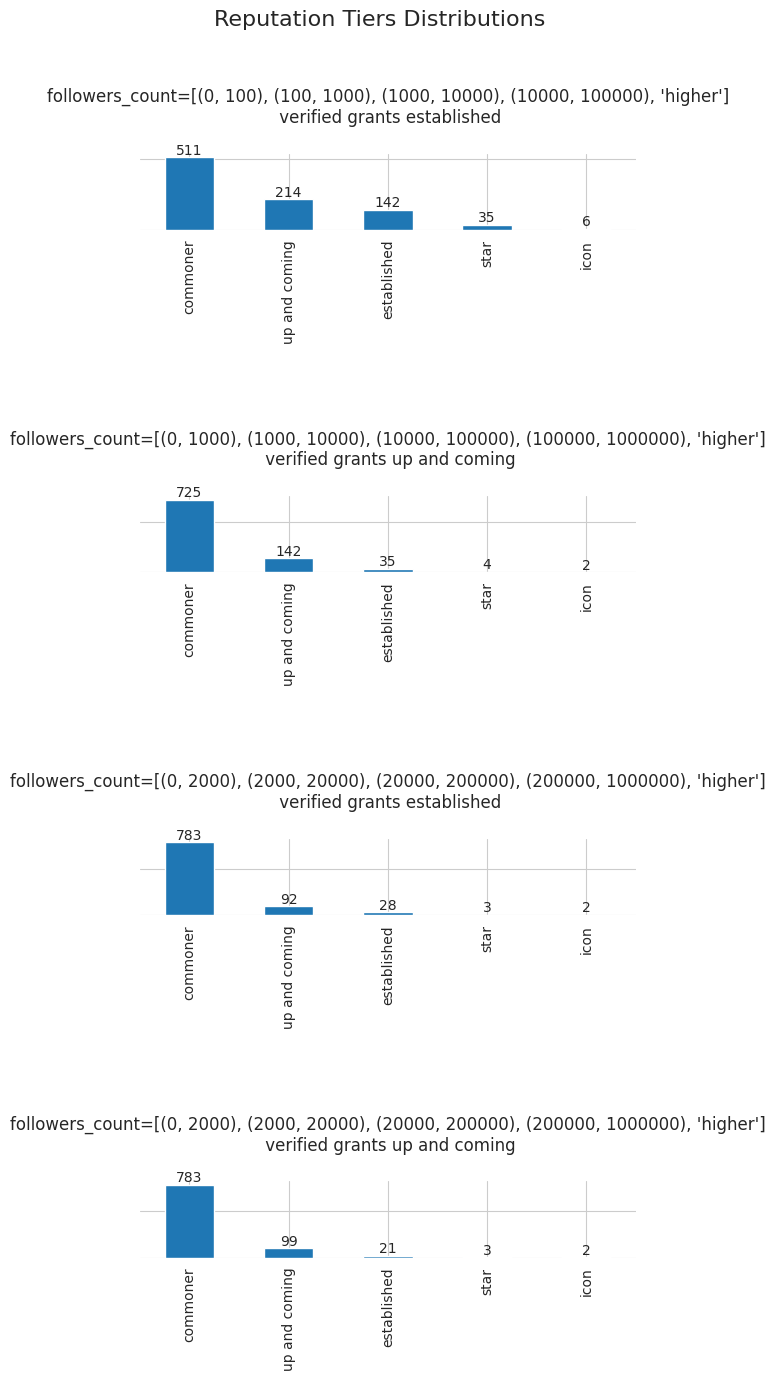

In [12]:
import matplotlib.pyplot as plt
from tiers import TIERS, get_bin

BINS = [[(0, 100), (100, 1000), (1000, 10000), (10000, 100000), (100000, df['followers_count'].max())],
        [(0, 1000), (1000, 10000), (10000, 100000), (100000, 1000000), (1000000, df['followers_count'].max())],
        [(0, 2000), (2000, 20000), (20000, 200000), (200000, 1000000), (1000000, df['followers_count'].max())],
        [(0, 2000), (2000, 20000), (20000, 200000), (200000, 1000000), (1000000, df['followers_count'].max())],
        ]

VERIFIEDS = [2, 1, 2, 1]

def reputation_func(n):
    def rep_func(followers_count, cap, verified):
        if cap >= 0.95:
            return TIERS[0]
        followers_bin = get_bin(followers_count, BINS[n])
        return TIERS[max(followers_bin, VERIFIEDS[n])] if verified else TIERS[followers_bin]

    return rep_func

fig2 = plt.figure()
fig2.suptitle('Reputation Tiers Distributions', fontsize=16, y=3.6)

for i in range(len(BINS)):
    df[f'reputation{i}'] = df.apply(lambda x: reputation_func(i)(x['followers_count'], x['cap_universal'], x['verified'])['name'], axis=1)
    ax = fig2.add_subplot(4, 1, i + 1)
    ax.set_title(f'followers_count={BINS[i][:-1] + ["higher"]}\n verified grants {TIERS[VERIFIEDS[i]]["name"]}', y=1.3)
    ax.axes.get_yaxis().set_visible(False)
    ax.bar_label(df[f'reputation{i}'].value_counts().plot.bar(ax=ax).containers[0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left = False, right = False , labelleft = False, bottom = False)

plt.subplots_adjust(top=3.3, bottom=1, hspace=3.5)
plt.show()
fig2.savefig('../plots/twitter/twitter_reputation_sims.png', bbox_inches='tight')

## Conclusion
- quantitative threshold: `followers`, `cap_universal`

Reputation algorithm:

|                         followers                         |    < 100    |     < 1k      |    < 10k    |  < 100k  |  100k+   |
|:---------------------------------------------------------:|:-----------:|:-------------:|:-----------:|:--------:|:--------:|
|          is likely bot (botometer `cap` >= 0.95)          |  commoner   |   commoner    |  commoner   | commoner | commoner |
| is likely not bot (botometer `cap` < 0.95) & not verified |  commoner   | up-and-coming | established |   star   |   icon   |
| is likely not bot (botometer `cap` < 0.95) & not verified |  commoner   | up-and-coming | established |   star   |   icon   |
|   is likely not bot (botometer `cap` < 0.95) & verified   | established |  established  | established |   star   |   icon   |


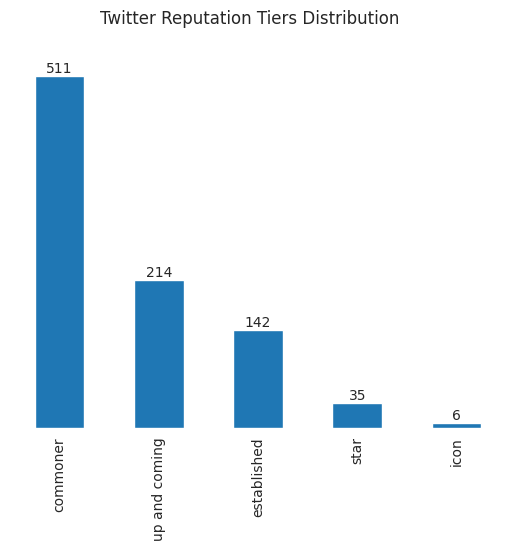

In [15]:
BINS = [(0, 100), (100, 1000), (1000, 10000), (10000, 100000),
         (100000, df['followers_count'].max() + 1)]

def rep_func_final(followers, cap_universal, verified):
    if cap_universal >= 0.95:
        return TIERS[0]

    followers_bin = get_bin(followers, BINS)
    return TIERS[max(followers_bin, 2)] if verified else TIERS[followers_bin]

df['reputation_final'] = df.apply(lambda x: rep_func_final(x['followers_count'], x['cap_universal'], x['verified'])['name'], axis=1)

fig_final = plt.figure()
fig_final.suptitle('Twitter Reputation Tiers Distribution')

ax = fig_final.add_subplot(1, 1, 1)
ax.axes.get_yaxis().set_visible(False)
ax.bar_label(df[f'reputation_final'].value_counts().plot.bar(ax=ax).containers[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left = False, right = False , labelleft = False, bottom = False)

plt.grid(False)
plt.show()
fig_final.savefig('../plots/twitter/reputation_final.png', bbox_inches='tight')